In [16]:
from time import time
import os
import numpy as np
import matplotlib.pyplot as plt


import matplotlib.patches as patches


%matplotlib inline

from matplotlib import animation, rc
from IPython.display import HTML, Image
rc('animation', html='html5')
import matplotlib.animation as animation
FFwriter = animation.FFMpegWriter()
Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)
animation.writers.list()

# (I don't really know wich one of these lines actually works)

['ffmpeg', 'ffmpeg_file', 'imagemagick', 'imagemagick_file', 'html']

In [17]:
# Temporal resolution
dt=0.001

# Cavendish constant
G=30

# The spaces
box=10
vspace=50
mspace=20

# Rate of change of velocity, due to viscosity or something. σ=1 means vaccuum.
σ=1.

In [18]:
class Star:
    def __init__(self,r_vec_arg,v_vec_arg,mass_arg):
        self.m=float(mass_arg)
        self.r=vfloat(np.array(r_vec_arg))
        self.v=vfloat(np.array(v_vec_arg))
        self.radius=np.sqrt(self.m/720)
    def move(self,a0):
        self.v+=a0*dt*σ
        self.r+=self.v*dt

In [19]:
norm=np.linalg.norm
random=np.random.uniform
vfloat=np.vectorize(float)

def F(a,b):
    '''
    Calculates the gravitational force that b exerts on a.
    '''
    return G*(b.m)/(norm(a.r-b.r)**3)*(b.r-a.r)

def Total_Force(star_key):
    '''
    Calculates the total force on the star with a certain key.
    '''
    acc=0
    for i in [q for q in s.keys() if q!=star_key]:
        acc+=F(s[star_key],s[i])
    return acc
            
#For a safe box. 
o=0.99

def bounce():
    '''
    Checks if the "star" it's going outside the screen and bounce it. 
    I know, this make no sense, but i don't want to check scape velocity from the system.
    And maybe I would just delete the stars that scape from screen, but... bah. 
    '''
    for i in s.keys():
        # horizontal positive
        if s[i].r[0]>=o*box:
            s[i].v[0]*=-1
            s[i].r[0]=o*box
        # vertical positive
        if s[i].r[1]>=o*box:
            s[i].v[1]*=-1
            s[i].r[1]=o*box
        # horizontal negative
        if s[i].r[0]<=-o*box:
            s[i].v[0]*=-1
            s[i].r[0]=-o*box
        # vertical negative
        if s[i].r[1]<=-o*box:
            s[i].v[1]*=-1
            s[i].r[1]=-o*box

def merge(a,b):
    global merges
    global totalmerges
    '''
    Check if stars s[a] and s[b] would collide, and if so, replaces it, 
    conservating the moment and adding the masses.
    '''
    if ( norm(s[a].r-s[b].r)<=0.3*(s[a].radius+s[b].radius) ):
        maxkey=max(list(s.keys()))
        newp=(s[a].m*s[a].v+s[b].m*s[b].v)
        newm=(s[a].m+s[b].m)
        newv=(newp/newm)
        newr=CM(a,b)
        #print("Merge!")
        s[a]=Star(newr,newv,newm)
        del s[b]
        merges+=1

def CM(a,b):
    '''
    Calculate the center of mass of s[a] and s[b]
    '''
    return ((s[a].m*s[a].r)+(s[b].m*s[b].r))/(s[a].m+s[b].m)

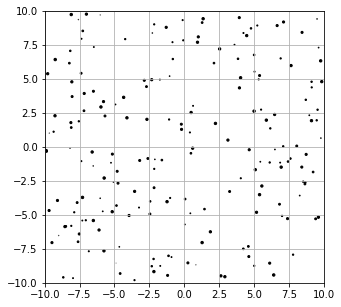

In [20]:
############# Initialize Stars dict
s={}

for i in range(1,200,1):
    s[i]=Star(random(-o*box,o*box,2),random(-vspace,vspace,2),random(0,mspace,1))

# For a little light example, comment all the last for and uncomment the following.

#s[1]=Star([0,0],[0,0],400)
#s[2]=Star([5,0],[-30,0],10)
#s[3]=Star([0,6],[-30,-2],2)

masses=np.array([s[i].m for i in s.keys()])*0.3

# Shows the initial conditions

fig, ax = plt.subplots(figsize=(5,5))
plt.scatter([s[q].r[0] for q in s.keys()],[s[q].r[1] for q in s.keys()],s=masses,c='k')
plt.xlim([-box,box]);plt.ylim([-box,box]);plt.grid("on");

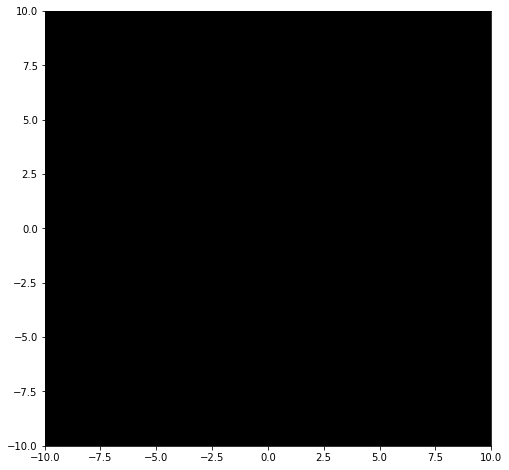

In [21]:
# The background.

fig, ax = plt.subplots(figsize=(8,8))
x, y = [],[] # not really necessary, could be initialized on everything, but needs to be defined.
ax.set_facecolor((0, 0, 0))
sc = ax.scatter(x,y,ss,c='w') # sc.set_offsets and set_sizes will update the data.
plt.xlim([-box,box]);plt.ylim([-box,box]);plt.grid("off");

In [22]:
times=[time()]
partialtimes=[0]
totalmerges=0
merges=0
partialmerges=[0]
particles=[len(s.keys())]
frame=[]
def animate(i):
    global times,partialtimes,merges,partialmerges,particles,frame
    Keys=list(s.keys())
    masses=[s[i].m for i in Keys]
    for j in Keys:
        try:
            s[j].move(Total_Force(j))
            for k in [q for q in Keys if q!=j]:
                merge(j,k)
        except KeyError:
            Keys=list(s.keys())
            masses=[s[i].m for i in Keys]
            continue

    # If you want an "infinity" box, comment this little guy
    bounce()
    
    # Update de data
    x=[s[q].r[0] for q in s.keys()]
    y=[s[q].r[1] for q in s.keys()]
    ss=np.array([s[q].m for q in s.keys()])*0.3
    sc.set_offsets(np.c_[x,y])
    sc.set_sizes(ss)
    
    #Print and save some data about the simulation.
    if (i>0 and i%10==0):
        times.append(time())
        partialtimes.append(times[-1]-times[-2])
        partialmerges.append(merges)
        particles.append(len(s.keys()))
        frame.append(i)
        merges=0
        print(i, "\t",times[-1]-start,"\t",partialtimes[-1])

In [23]:
start=time()
print("Frame\t Total time\t\tLast 10 frames time (ignore first number) ")
sim = animation.FuncAnimation(fig, animate, frames=600, interval=100, repeat=True) 
sim

Frame	 Total time		Last 10 frames time (ignore first number) 
10 	 16.822018146514893 	 16.83562159538269
20 	 27.60792374610901 	 10.785905599594116
30 	 37.66246151924133 	 10.054537773132324
40 	 46.62110447883606 	 8.958642959594727
50 	 54.248263359069824 	 7.627158880233765
60 	 60.41413617134094 	 6.165872812271118
70 	 65.90251469612122 	 5.488378524780273
80 	 70.64765477180481 	 4.745140075683594
90 	 74.8738043308258 	 4.226149559020996
100 	 78.47590279579163 	 3.6020984649658203
110 	 81.5293185710907 	 3.0534157752990723
120 	 84.01034879684448 	 2.481030225753784
130 	 85.86830568313599 	 1.857956886291504
140 	 87.44645977020264 	 1.5781540870666504
150 	 88.88790678977966 	 1.4414470195770264
160 	 90.0616295337677 	 1.173722743988037
170 	 91.1022162437439 	 1.0405867099761963
180 	 91.96842408180237 	 0.8662078380584717
190 	 92.74906158447266 	 0.7806375026702881
200 	 93.44465065002441 	 0.6955890655517578
210 	 94.1605064868927 	 0.7158558368682861
220 	 94.841946

In [24]:
print("Global time:\t",time()-start)

Global time:	 117.76405239105225


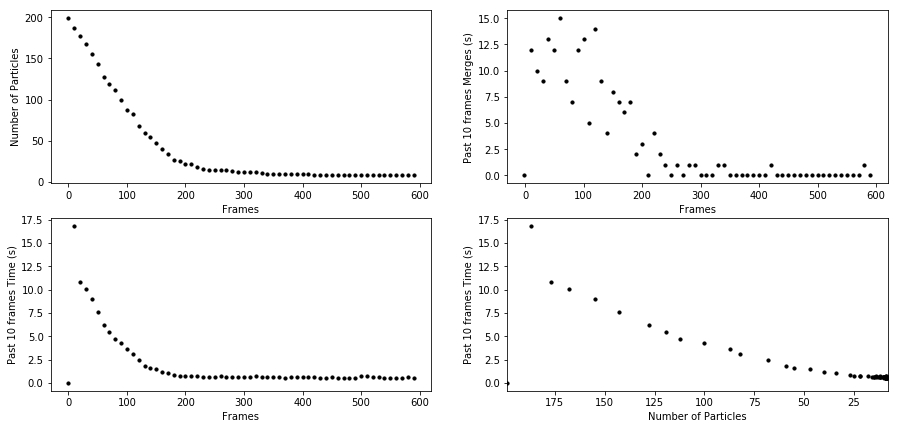

In [25]:
fig2,ax2= plt.subplots(2,2,figsize=(15,7))

ax2[0,0].scatter([-1]+frame,particles,s=10,c='k')
ax2[0,0].set_xlabel("Frames",fontsize=10)
ax2[0,0].set_ylabel("Number of Particles",fontsize=10)

ax2[1,0].scatter([-1]+frame,partialtimes,s=10,c='k')
ax2[1,0].set_xlabel("Frames",fontsize=10)
ax2[1,0].set_ylabel("Past 10 frames Time (s)",fontsize=10)

ax2[0,1].scatter([-1]+frame,partialmerges,s=10,c='k')
ax2[0,1].set_xlabel("Frames",fontsize=10)
ax2[0,1].set_ylabel("Past 10 frames Merges (s)",fontsize=10)

ax2[1,1].scatter(particles,partialtimes,s=10,c='k')
ax2[1,1].set_xlabel("Number of Particles",fontsize=10)
ax2[1,1].set_ylabel("Past 10 frames Time (s)",fontsize=10)
ax2[1,1].set_xlim([max(particles),min(particles)]);

In [26]:
# total merges
np.sum(partialmerges)

191